In [1]:
import pandas as pd
import torch
import torch.nn as nn
# import vaex
import numpy as np
import glob
import dask.dataframe as dd
import json
from sklearn.model_selection import train_test_split
import math
import csv
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import time
import _warnings
from tqdm import tqdm
import swifter
import argparse
import os
from copy import copy, deepcopy
from pathlib import Path
from concurrent import futures
from functools import partial
import tensorflow as tf
from itertools import chain
from torchvision import utils

import torch.optim as optim
from torch.autograd import Variable
from torch import autograd
import time as t

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

SAVE_PER_TIMES = 100

from torch.utils.data import Dataset, DataLoader

/home/tiendat/miniconda3/envs/torchtf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.create_file_writer(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        with self.writer.as_default():
            tf.summary.scalar(tag, data=value, step=step)

    def image_summary(self, tag, images, step):
        """Log a list of images.
        Args::images: numpy of shape (Batch x C x H x W) in the range [-1.0, 1.0]
        """
        with self.writer.as_default():
            imgs = None
            for i, j in enumerate(images):
                img = ((j*0.5+0.5)*255).round().astype('uint8')
                if len(img.shape) == 3:
                    img = img.transpose(1, 2, 0)
                else:
                    img = img[:, :, np.newaxis]
                img = img[np.newaxis, :]
                if not imgs is None:
                    imgs = np.append(imgs, img, axis=0)
                else:
                    imgs = img
            tf.summary.image('{}'.format(tag), imgs, max_outputs=len(imgs), step=step)

    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""
        with self.writer.as_default():
            tf.summary.histogram('{}'.format(tag), values, buckets=bins, step=step)

In [3]:
class Generator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [1024, 512, 256]
        # Input_dim = 100
        # Output_dim = C (number of channels)
        self.main_module = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=(4, 3), stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(4, 4), stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # State (256x16x16)
            nn.ConvTranspose2d(in_channels=256, out_channels=channels, kernel_size=(4, 4), stride=2, padding=(1, 2)))
            # output of main module --> Image (Cx37x28)

        self.output = nn.Tanh()

    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)


class Discriminator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [256, 512, 1024]
        # Input_dim = channels (Cx37x28)
        # Output_dim = 1
        self.main_module = nn.Sequential(
            # Omitting batch normalization in critic because our new penalized training objective (WGAN with gradient penalty) is no longer valid
            # in this setting, since we penalize the norm of the critic's gradient with respect to each input independently and not the enitre batch.
            # There is not good & fast implementation of layer normalization --> using per instance normalization nn.InstanceNorm2d()
            # Image (Cx37x28)
            nn.Conv2d(in_channels=channels, out_channels=256, kernel_size=(4, 4), stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x18x13)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4, 4), stride=2, padding=1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x6)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(4, 4), stride=2, padding=1),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
            # output of main module --> State (1024x3x2)

        self.output = nn.Sequential(
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=(3, 2), stride=1, padding=0))


    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

    def feature_extraction(self, x):
        # Use discriminator for feature extraction then flatten to vector of 16384
        x = self.main_module(x)
        return x.view(-1, 1024*3*2)
    
class WGAN_GP(object):
    def __init__(self):
        print("WGAN_GradientPenalty init model.")
        self.G = Generator(1)
        self.D = Discriminator(1)
        self.C = 1

        # Check if cuda is available
        self.check_cuda(True)

        # WGAN values from paper
        self.learning_rate = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.batch_size = 64

        # WGAN_gradient penalty uses ADAM
        # self.d_optimizer = optim.Adam(self.D.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))
        # self.g_optimizer = optim.Adam(self.G.parameters(), lr=self.learning_rate, betas=(self.b1, self.b2))
        self.d_optimizer = optim.RMSprop(self.D.parameters(), lr=self.learning_rate)
        self.g_optimizer = optim.RMSprop(self.G.parameters(), lr=self.learning_rate)

        # Set the logger
        self.logger = Logger('./logs')
        self.logger.writer.flush()
        self.number_of_images = 10

        self.generator_iters = 20000 #args.generator_iters
        self.critic_iter = 5
        self.lambda_term = 10

    def get_torch_variable(self, arg):
        if self.cuda:
            return Variable(arg).cuda(self.cuda_index)
        else:
            return Variable(arg)

    def check_cuda(self, cuda_flag=False):
        print(cuda_flag)
        if cuda_flag:
            self.cuda_index = 0
            self.cuda = True
            self.D.cuda(self.cuda_index)
            self.G.cuda(self.cuda_index)
            print("Cuda enabled flag: {}".format(self.cuda))
        else:
            self.cuda = False

    def generate_synthetic_samples(self, minority_data_loader):
        self.t_begin = t.time()
        self.file = open("inception_score_graph.txt", "w+")

        # Now batches are callable self.data.next()
        self.data = self.get_infinite_batches(minority_data_loader)

        one = torch.tensor(1, dtype=torch.float)
        mone = one * -1
        if self.cuda:
            one = one.cuda(self.cuda_index)
            mone = mone.cuda(self.cuda_index)

        for g_iter in range(self.generator_iters):
            # Requires grad, Generator requires_grad = False
            for p in self.D.parameters():
                p.requires_grad = True

            # d_loss_real = 0
            # d_loss_fake = 0
            # Wasserstein_D = 0
            # Train Dicriminator forward-loss-backward-update self.critic_iter times while 1 Generator forward-loss-backward-update
            for d_iter in range(self.critic_iter):
                self.D.zero_grad()

                images = self.data.__next__()
                # Check for batch to have full batch_size
                if (images.size()[0] != self.batch_size):
                    continue

                z = torch.rand((self.batch_size, 100, 1, 1))

                images, z = self.get_torch_variable(images), self.get_torch_variable(z)

                # Train discriminator
                # WGAN - Training discriminator more iterations than generator
                # Train with real images
                d_loss_real = self.D(images)
                d_loss_real = d_loss_real.mean()
                d_loss_real.backward(mone)

                # Train with fake images
                z = self.get_torch_variable(torch.randn(self.batch_size, 100, 1, 1))

                fake_images = self.G(z)
                d_loss_fake = self.D(fake_images)
                d_loss_fake = d_loss_fake.mean()
                d_loss_fake.backward(one)

                # Train with gradient penalty
                gradient_penalty = self.calculate_gradient_penalty(images.data, fake_images.data)
                gradient_penalty.backward()


                d_loss = d_loss_fake - d_loss_real + gradient_penalty
                Wasserstein_D = d_loss_real - d_loss_fake
                self.d_optimizer.step()
                print(f'  Discriminator iteration: {d_iter}/{self.critic_iter}, loss_fake: {d_loss_fake}, loss_real: {d_loss_real}')

            # Generator update
            for p in self.D.parameters():
                p.requires_grad = False  # to avoid computation

            self.G.zero_grad()
            # train generator
            # compute loss with fake images
            z = self.get_torch_variable(torch.randn(self.batch_size, 100, 1, 1))
            fake_images = self.G(z)
            g_loss = self.D(fake_images)
            g_loss = g_loss.mean()
            g_loss.backward(mone)
            g_cost = -g_loss
            self.g_optimizer.step()
            print(f'Generator iteration: {g_iter}/{self.generator_iters}, g_loss: {g_loss}')
            
            # Saving model and sampling images every 1000th generator iterations
            if (g_iter) % SAVE_PER_TIMES == 0:
                self.save_model()
                # # Workaround because graphic card memory can't store more than 830 examples in memory for generating image
                # # Therefore doing loop and generating 800 examples and stacking into list of samples to get 8000 generated images
                # # This way Inception score is more correct since there are different generated examples from every class of Inception model
                # sample_list = []
                # for i in range(125):
                #     samples  = self.data.__next__()
                # #     z = Variable(torch.randn(800, 100, 1, 1)).cuda(self.cuda_index)
                # #     samples = self.G(z)
                #     sample_list.append(samples.data.cpu().numpy())
                # #
                # # # Flattening list of list into one list
                # new_sample_list = list(chain.from_iterable(sample_list))
                # print("Calculating Inception Score over 8k generated images")
                # # # Feeding list of numpy arrays
                # inception_score = get_inception_score(new_sample_list, cuda=True, batch_size=32,
                #                                       resize=True, splits=10)

                if not os.path.exists('training_result_images/'):
                    os.makedirs('training_result_images/')

                # Denormalize images and save them in grid 8x8
                z = self.get_torch_variable(torch.randn(800, 100, 1, 1))
                samples = self.G(z)
                samples = samples.mul(0.5).add(0.5)
                samples = samples.data.cpu()[:64]
                grid = utils.make_grid(samples)
                utils.save_image(grid, 'training_result_images/img_generatori_iter_{}.png'.format(str(g_iter).zfill(3)))

                # Testing
                time = t.time() - self.t_begin
                #print("Real Inception score: {}".format(inception_score))
                print("Generator iter: {}".format(g_iter))
                print("Time {}".format(time))

                # Write to file inception_score, gen_iters, time
                #output = str(g_iter) + " " + str(time) + " " + str(inception_score[0]) + "\n"
                #self.file.write(output)


                # ============ TensorBoard logging ============#
                # (1) Log the scalar values
                info = {
                    'Wasserstein distance': Wasserstein_D.data,
                    'Loss D': d_loss.data,
                    'Loss G': g_cost.data,
                    'Loss D Real': d_loss_real.data,
                    'Loss D Fake': d_loss_fake.data

                }

                for tag, value in info.items():
                    self.logger.scalar_summary(tag, value.cpu(), g_iter + 1)

                # (3) Log the images
                info = {
                    'real_images': self.real_images(images, self.number_of_images),
                    'generated_images': self.generate_img(z, self.number_of_images)
                }

                for tag, images in info.items():
                    self.logger.image_summary(tag, images, g_iter + 1)



        self.t_end = t.time()
        print('Time of training-{}'.format((self.t_end - self.t_begin)))
        #self.file.close()

        # Save the trained parameters
        # self.save_model()
        return fake_images.data.cpu().numpy()

    def evaluate(self, test_loader, D_model_path, G_model_path):
        self.load_model(D_model_path, G_model_path)
        z = self.get_torch_variable(torch.randn(self.batch_size, 100, 1, 1))
        samples = self.G(z)
        samples = samples.mul(0.5).add(0.5)
        samples = samples.data.cpu()
        grid = utils.make_grid(samples)
        print("Grid of 8x8 images saved to 'dgan_model_image.png'.")
        utils.save_image(grid, 'dgan_model_image.png')


    def calculate_gradient_penalty(self, real_images, fake_images):
        eta = torch.FloatTensor(self.batch_size,1,1,1).uniform_(0,1)
        eta = eta.expand(self.batch_size, real_images.size(1), real_images.size(2), real_images.size(3))
        if self.cuda:
            eta = eta.cuda(self.cuda_index)
        else:
            eta = eta

        interpolated = eta * real_images + ((1 - eta) * fake_images)

        if self.cuda:
            interpolated = interpolated.cuda(self.cuda_index)
        else:
            interpolated = interpolated

        # define it to calculate gradient
        interpolated = Variable(interpolated, requires_grad=True)

        # calculate probability of interpolated examples
        prob_interpolated = self.D(interpolated)

        # calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(
                                   prob_interpolated.size()).cuda(self.cuda_index) if self.cuda else torch.ones(
                                   prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # flatten the gradients to it calculates norm batchwise
        gradients = gradients.view(gradients.size(0), -1)
        
        grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.lambda_term
        return grad_penalty

    def real_images(self, images, number_of_images):
        if (self.C == 3):
            return self.to_np(images.view(-1, self.C, 32, 32)[:self.number_of_images])
        else:
            return self.to_np(images.view(-1, 32, 32)[:self.number_of_images])

    def generate_img(self, z, number_of_images):
        samples = self.G(z).data.cpu().numpy()[:number_of_images]
        generated_images = []
        for sample in samples:
            if self.C == 3:
                generated_images.append(sample.reshape(self.C, 32, 32))
            else:
                generated_images.append(sample.reshape(32, 32))
        return generated_images

    def to_np(self, x):
        return x.data.cpu().numpy()

    def save_model(self):
        torch.save(self.G.state_dict(), './generator.pkl')
        torch.save(self.D.state_dict(), './discriminator.pkl')
        print('Models save to ./generator.pkl & ./discriminator.pkl ')

    def load_model(self, D_model_filename, G_model_filename):
        D_model_path = os.path.join(os.getcwd(), D_model_filename)
        G_model_path = os.path.join(os.getcwd(), G_model_filename)
        self.D.load_state_dict(torch.load(D_model_path))
        self.G.load_state_dict(torch.load(G_model_path))
        print('Generator model loaded from {}.'.format(G_model_path))
        print('Discriminator model loaded from {}-'.format(D_model_path))

    def get_infinite_batches(self, data_loader):
        while True:
            for i, (images, _) in enumerate(data_loader):
                yield images

    def generate_latent_walk(self, number):
        if not os.path.exists('interpolated_images/'):
            os.makedirs('interpolated_images/')

        number_int = 10
        # interpolate between twe noise(z1, z2).
        z_intp = torch.FloatTensor(1, 100, 1, 1)
        z1 = torch.randn(1, 100, 1, 1)
        z2 = torch.randn(1, 100, 1, 1)
        if self.cuda:
            z_intp = z_intp.cuda()
            z1 = z1.cuda()
            z2 = z2.cuda()

        z_intp = Variable(z_intp)
        images = []
        alpha = 1.0 / float(number_int + 1)
        print(alpha)
        for i in range(1, number_int + 1):
            z_intp.data = z1*alpha + z2*(1.0 - alpha)
            alpha += alpha
            fake_im = self.G(z_intp)
            fake_im = fake_im.mul(0.5).add(0.5) #denormalize
            images.append(fake_im.view(self.C,32,32).data.cpu())

        grid = utils.make_grid(images, nrow=number_int )
        utils.save_image(grid, 'interpolated_images/interpolated_{}.png'.format(str(number).zfill(3)))
        print("Saved interpolated images.")

In [4]:
import os
import numpy as np
import pandas as pd

# Directory containing the .npz files
directory = ['../data/non_ksm_transformer/train', '../data/non_ksm_transformer/val']

# List to hold the data


# Loop through all files in the directory
for dir in directory:
    data_list = []
    label_list = []
    for filename in os.listdir(dir):
        if filename.endswith('.npz'):
            # Load the .npz file
            file_path = os.path.join(dir, filename)
            with np.load(file_path) as data:
                # Assuming the .npz file contains arrays, extract them
                consump = data['X'] 
                label = data['y']
                
                data_list.append(consump.flatten().tolist())
                label_list.append(label.flatten().tolist()[0])
    if 'train' in dir:
        train_data = pd.DataFrame(data_list)
        train_data['label'] = label_list
    else:
        val_data = pd.DataFrame(data_list)
        val_data['label'] = label_list

train_data

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,4.96,4.40,5.68,7.87,5.55,6.62,7.85,0.0,0.0,0
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,1.74,1.91,1.81,2.16,1.89,1.98,1.89,0.0,0.0,0
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,2.37,3.01,2.90,2.88,3.97,2.72,3.25,0.0,0.0,0
3,9.34000,15.16000,14.40000,15.24000,14.63000,13.62000,13.01,15.39000,11.35000,8.08,...,11.86,13.60,17.86,13.38,14.01,11.20,12.91,0.0,0.0,1
4,0.77000,0.77000,0.68000,0.01000,0.10000,0.03000,0.09,0.04000,0.25000,0.84,...,1.27,1.54,1.70,0.98,0.75,1.33,0.56,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25342,0.25000,0.65000,1.53000,5.73000,5.26000,1.60000,0.99,1.18000,0.96000,1.10,...,11.66,11.54,10.69,11.24,11.08,9.14,10.12,0.0,0.0,0
25343,16.37371,16.37371,16.37371,16.37371,16.37371,16.37371,13.22,16.37371,16.37371,16.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1
25344,3.91000,5.59000,4.50000,5.31000,2.91000,3.98000,3.33,4.22000,6.38000,6.02,...,4.76,3.13,5.95,6.01,3.03,4.49,2.30,0.0,0.0,0
25345,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.0,0


In [5]:
minority_data = train_data[train_data['label'] == 1]
majority_data = train_data[train_data['label'] == 0]
minority_data.shape, majority_data.shape

((2024, 1037), (23323, 1037))

In [6]:
y_minor = minority_data['label']
x_minor = minority_data.drop(columns=['label'])

In [7]:
x_minor['data'] = x_minor[x_minor.columns].values.tolist()
df_apr = x_minor['data']

In [8]:
import torch.nn.functional as F

window_size = 28 # 4weeks
output_shape = (1036 // window_size, window_size)
strided_size = output_shape[0]

# padded_arr = np.pad(arr, (0, 1089 - len(arr)), 'constant')
# matrix1 = padded_arr.reshape(33, 33)

# print(np.arange(20))
# np.lib.stride_tricks.as_strided(np.arange(30), (6,5), (8*5, 8))

class MinorityDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe['data'].values
        self.labels = dataframe['label'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return sample, label

def stride(x):
    as_strided = np.lib.stride_tricks.as_strided
    # x = pd.Series(x) # no padding
    # print(len(x)) 1034 
    x = np.pad(pd.Series(x), (0, 2), 'constant') # padding 
    return as_strided(x, output_shape, (8*window_size, 8))
df_apr = df_apr.apply(stride)
df_dpr = df_apr.to_frame()
df_dpr['label'] = y_minor

# Assuming df_dpr is your DataFrame
minor_dataset = MinorityDataset(df_dpr)
minority_dataloader = DataLoader(minor_dataset, batch_size=64, shuffle=True)

In [ ]:
model = WGAN_GP()

generated_data = model.generate_synthetic_samples(minority_dataloader)

In [106]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def anwu(T, T_pos, T_neg, T_gen, k, w_pos=1):
    """
    Implements the Adaptive Neighborhood-based Weighted Undersampling (ANWU) algorithm.

    Parameters:
    - T: Combined dataset (includes T_pos, T_neg, and T_gen)
    - T_pos: Positive instances in T (minority class)
    - T_neg: Negative instances in T (majority class)
    - T_gen: Generated instances in T (synthetic minority class)
    - k: Number of nearest neighbors
    - w_pos: Weight for positive instances (default is 1)

    Returns:
    - T: Final balanced dataset
    """

    lmb = 0  # Initialize lmb counter
    
    # Convert data to numpy arrays for easier manipulation
    T_gen = np.array(T_gen)
    T_neg = np.array(T_neg)
    T_pos = np.array(T_pos)
    T = np.array(T)
    
    # Step 3: Iterate over each instance in T_gen
    nbrs = NearestNeighbors(n_neighbors=k).fit(T)
    for x in T_gen:
        N = nbrs.kneighbors([x], return_distance=False)[0]  # Find k-nearest neighbors of x in T
        N_samples = T[N]  # Get actual neighbor samples
        
        N_neg = np.sum(np.isin(N_samples, T_neg))  # Count negative (majority) members in N
        N_pos = np.sum(np.isin(N_samples, T_pos))  # Count positive (minority) members in N
        
        # Step 7: Remove x from T_gen if majority neighbors are more than half
        if N_neg > k / 2:
            T = np.array([t for t in T if not np.array_equal(t, x)])  # Remove x from T
            lmb += 1

    # Step 12: Iterate over each instance in T_neg
    weights = []
    for x in T_neg:
        N = nbrs.kneighbors([x], return_distance=False)[0]  # Find k-nearest neighbors of x in T
        N_samples = T[N]  # Get actual neighbor samples
        
        N_pos = np.sum(np.isin(N_samples, T_pos))  # Count positive (minority) members in N
        N_gen = np.sum(np.isin(N_samples, T_gen))  # Count generated members in N
        
        # Calculate weight for the current x instance
        weight_x = w_pos * N_pos + N_gen
        weights.append((x, weight_x))

    # Sort T_neg instances by weight and remove lmb instances with the largest weight
    weights.sort(key=lambda tup: tup[1], reverse=True)
    T_neg_to_remove = [tup[0] for tup in weights[:lmb]]
    
    for x in T_neg_to_remove:
        T = np.array([t for t in T if not np.array_equal(t, x)])  # Remove x from T

    return T

# Example Usage:
# Assuming T, T_pos, T_neg, T_gen are defined and contain the dataset samples
# k = 5  # Number of nearest neighbors
# w_pos = 1  # Weight for positive instances
# final_balanced_data = anwu(T, T_pos, T_neg, T_gen, k, w_pos)

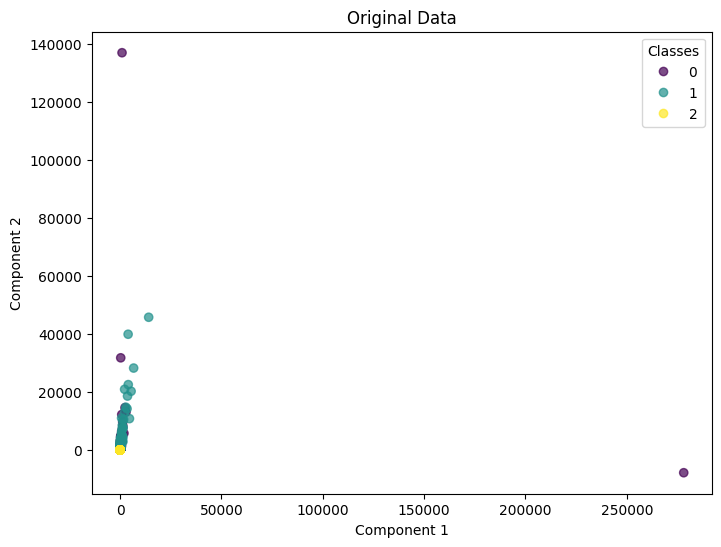

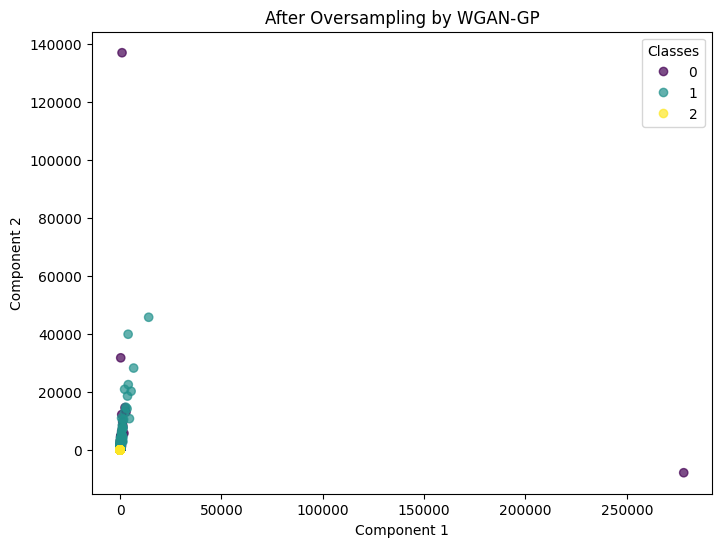

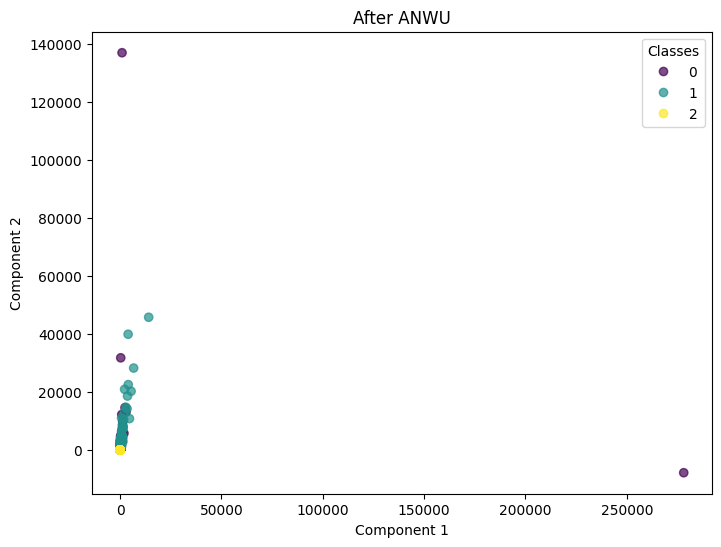

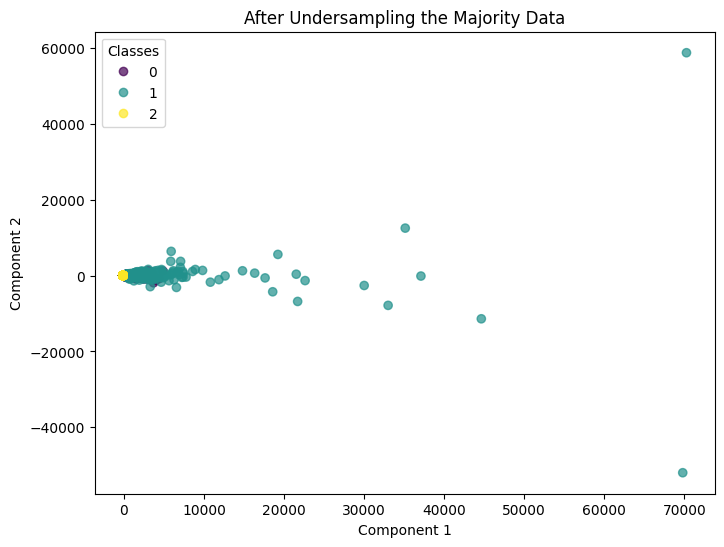

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from collections import Counter
from numpy import where

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# Step 1: Flatten your data if it's not already flattened
def flatten_data(data):
    return np.array([x.flatten() for x in data])

# Step 2: Dimensionality Reduction for Visualization
def reduce_dimensions(data, method='pca', n_components=2):
    if method == 'pca':
        reducer = PCA(n_components=n_components)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components)
    return reducer.fit_transform(data)

# Step 3: Visualize the Data
def visualize_data(X, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

# # Simulate data (replace with your actual data)
filename = '../data/minority.npz'
dataloader_min = np.load(filename, allow_pickle=True)
X_minority, label = dataloader_min['data'], dataloader_min['label']

filename = '../data/GAN_data.npz'
dataloader_maj = np.load(filename, allow_pickle=True)
X_generated, label = dataloader_maj['data'], dataloader_maj['label']

filename = '../data/majority.npz'
dataloader_gan = np.load(filename, allow_pickle=True)
X_majority, label = dataloader_gan['data'], dataloader_gan['label']

X_ori = np.vstack([flatten_data(X_majority), flatten_data(X_minority)])
y_ori = np.array([0] * len(X_majority) + [1] * len(X_minority))

X_afterGAN = np.vstack([flatten_data(X_majority), flatten_data(X_minority), flatten_data(X_generated)])
y_afterGAN = np.array([0] * len(X_majority) + [1] * len(X_minority) + [2] * len(X_generated))

# Plot original data (Fig. 3a)
# Reduce dimensions for visualization
X_ori_reduced = reduce_dimensions(X_afterGAN, method='pca')

# Visualize before ANWU
visualize_data(X_ori_reduced, y_afterGAN, 'Original Data')

# Step 1: Oversampling with WGAN-GP (represented by X_generated in this case)
# (Assumed already done, we visualize the generated data as part of the original dataset)

# Plot after WGAN-GP oversampling (Fig. 3b)

X_afterGAN_reduced = reduce_dimensions(X_afterGAN, method='pca')
visualize_data(X_afterGAN_reduced, y_afterGAN, 'After Oversampling by WGAN-GP')

# Step 2: ANWU Phase 1 - Undersample generated data with high overlap with majority class
def undersample_generated(X, y, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    generated_indices = np.where(y == 2)[0]
    to_remove = []

    for idx in generated_indices:
        N = nbrs.kneighbors([X[idx]], return_distance=False)[0]
        neighbors_labels = y[N]
        majority_count = np.sum(neighbors_labels == 0)

        if majority_count > k / 2:
            to_remove.append(idx)
    
    return np.delete(X, to_remove, axis=0), np.delete(y, to_remove)

# Apply undersampling to the generated data
X_minority_phase1, y_minority_phase1 = undersample_generated(X_afterGAN, y_afterGAN)

# Reduce dimensions again after ANWU
X_minority_phase1_reduced = reduce_dimensions(X_minority_phase1, method='pca')

# Visualize after ANWU
visualize_data(X_minority_phase1_reduced, y_minority_phase1, 'After ANWU')

# Step 3: ANWU Phase 2 - Weighted undersampling of the majority class
def weighted_undersample_majority(X, y, k=5, w_pos=2):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    majority_indices = np.where(y == 0)[0]
    weights = []

    for idx in majority_indices:
        N = nbrs.kneighbors([X[idx]], return_distance=False)[0]
        neighbors_labels = y[N]
        pos_count = np.sum(neighbors_labels == 1)
        gen_count = np.sum(neighbors_labels == 2)
        weight = w_pos * pos_count + gen_count
        weights.append((idx, weight))

    # Sort by weight and remove the highest weighted samples
    weights.sort(key=lambda x: x[1], reverse=True)
    lmb = len(weights) // 5  # Assume we remove 20% of the most overlapped samples
    to_remove = [w[0] for w in weights[:lmb]]

    return np.delete(X, to_remove, axis=0), np.delete(y, to_remove)

# Apply weighted undersampling to the majority class
X_majority_phase2, y_majority_phase2 = weighted_undersample_majority(X_minority_phase1, y_minority_phase1)

# Reduce dimensions again after ANWU
X_majority_phase2_reduced = reduce_dimensions(X_majority_phase2, method='pca')

# Plot after undersampling the majority data (Fig. 3d)
visualize_data(X_majority_phase2_reduced, y_majority_phase2, 'After Undersampling the Majority Data')

In [9]:
y_majority_phase2[y_majority_phase2 == 2] = 1
y_majority_phase2

array([0, 0, 0, ..., 1, 1, 1])

In [14]:
import pandas as pd

resample = pd.DataFrame(X_majority_phase2)
resample.head()

,0,1,2,3,4,5,6,7,8,9,...,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.00,2.83,2.97,2.85,1.58,1.10,0.74,0.00,0.0,0.0
1,24.37,28.73,18.50,23.13,23.39,27.58,20.74,25.12,20.45,22.65,...,15.71,13.40,16.51,12.72,19.11,17.35,13.50,12.68,0.0,0.0
2,12.88,5.22,2.18,2.71,0.00,0.00,1.91,2.05,2.31,0.00,...,21.45,19.11,20.18,19.38,23.08,13.13,2.56,2.53,0.0,0.0
3,4.76,7.45,6.73,7.10,8.38,6.99,5.99,4.60,7.08,6.86,...,6.25,6.19,6.35,6.87,2.72,1.73,4.42,5.51,0.0,0.0
4,65.12,54.62,56.47,60.50,65.84,59.36,60.20,50.27,58.83,54.86,...,46.53,47.23,50.39,47.09,51.74,52.39,46.93,39.81,0.0,0.0


In [15]:
#df_pr['data'] = df_pr[df_pr.columns].astype(float).values.tolist()
resample['data'] = resample[resample.columns].values.tolist()
df_apr = resample['data']
df_apr

0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [24.37, 28.73, 18.5, 23.13, 23.39, 27.58, 20.7...
2        [12.88, 5.22, 2.18, 2.71, 0.0, 0.0, 1.91, 2.05...
3        [4.76, 7.45, 6.73, 7.1, 8.38, 6.99, 5.99, 4.6,...
4        [65.12, 54.62, 56.47, 60.5, 65.84, 59.36, 60.2...
                               ...                        
44539    [0.24950240552425385, 0.1283407360315323, 0.16...
44540    [0.028743980452418327, -0.026560643687844276, ...
44541    [0.016872882843017578, 0.015836330130696297, 0...
44542    [0.3259444534778595, 0.2632644474506378, 0.148...
44543    [0.26933106780052185, 0.1166144460439682, 0.24...
Name: data, Length: 44544, dtype: object

In [16]:
import torch.nn.functional as F

window_size = 28 # 4weeks
output_shape = (1036 // window_size, window_size)
print(output_shape)
strided_size = output_shape[0]
print(strided_size)

# padded_arr = np.pad(arr, (0, 1089 - len(arr)), 'constant')
# matrix1 = padded_arr.reshape(33, 33)

# print(np.arange(20))
# np.lib.stride_tricks.as_strided(np.arange(30), (6,5), (8*5, 8))

def stride(x):
    as_strided = np.lib.stride_tricks.as_strided
    # x = pd.Series(x) # no padding
    # print(len(x)) 1034 
    x = np.pad(pd.Series(x), (0, 2), 'constant') # padding 
    return as_strided(x, output_shape, (8*window_size, 8))


(37, 28)
37


In [17]:
df_apr = df_apr.apply(stride)
df_apr

0        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1        [[24.37, 28.73, 18.5, 23.13, 23.39, 27.58, 20....
2        [[12.88, 5.22, 2.18, 2.71, 0.0, 0.0, 1.91, 2.0...
3        [[4.76, 7.45, 6.73, 7.1, 8.38, 6.99, 5.99, 4.6...
4        [[65.12, 54.62, 56.47, 60.5, 65.84, 59.36, 60....
                               ...                        
44539    [[0.24950240552425385, 0.1283407360315323, 0.1...
44540    [[0.028743980452418327, -0.026560643687844276,...
44541    [[0.016872882843017578, 0.015836330130696297, ...
44542    [[0.3259444534778595, 0.2632644474506378, 0.14...
44543    [[0.26933106780052185, 0.1166144460439682, 0.2...
Name: data, Length: 44544, dtype: object

In [18]:
df_dpr = df_apr.to_frame()
df_dpr['label'] = y_majority_phase2
df_dpr

,data,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,"[[24.37, 28.73, 18.5, 23.13, 23.39, 27.58, 20....",0
2,"[[12.88, 5.22, 2.18, 2.71, 0.0, 0.0, 1.91, 2.0...",0
3,"[[4.76, 7.45, 6.73, 7.1, 8.38, 6.99, 5.99, 4.6...",0
4,"[[65.12, 54.62, 56.47, 60.5, 65.84, 59.36, 60....",0
...,...,...
44539,"[[0.24950240552425385, 0.1283407360315323, 0.1...",1
44540,"[[0.028743980452418327, -0.026560643687844276,...",1
44541,"[[0.016872882843017578, 0.015836330130696297, ...",1
44542,"[[0.3259444534778595, 0.2632644474506378, 0.14...",1


In [19]:
data_dir = '../data'
save_file = f'{data_dir}/dataset_before_WGAN-ANWU.npz'
print('Saving to: ', save_file)
data = df_dpr['data']
label = df_dpr['label']
np.savez_compressed(save_file, data=data, label=label)

Saving to:  ../data/dataset_before_WGAN-ANWU.npz


In [100]:
import numpy as np
import pandas as pd

# Load data from .npz file
filename = '../data/minority.npz'
dataloader_min = np.load(filename, allow_pickle=True)
X_minority, label = dataloader_min['data'], dataloader_min['label']

# Flatten each 2D array in the rows
flattened_X_minority = np.array([x.flatten() for x in X_minority])

print(flattened_X_minority.shape)

(2523, 1036)


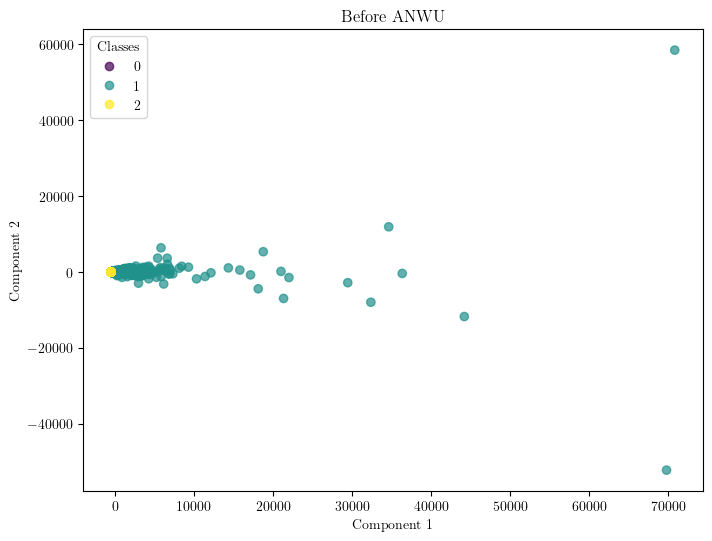

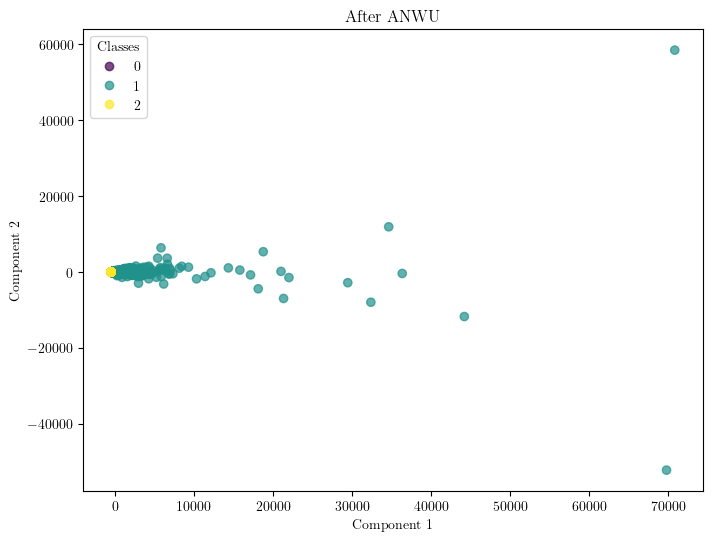

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# Step 1: Flatten your data if it's not already flattened
def flatten_data(data):
    return np.array([x.flatten() for x in data])

# Step 2: Dimensionality Reduction for Visualization
def reduce_dimensions(data, method='pca', n_components=2):
    if method == 'pca':
        reducer = PCA(n_components=n_components)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components)
    return reducer.fit_transform(data)

# Step 3: Visualize the Data
def visualize_data(X, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

filename = '../data/minority.npz'
dataloader_min = np.load(filename, allow_pickle=True)
X_minority, label = dataloader_min['data'], dataloader_min['label']

# Simulate data (replace with your actual data)
x_majority = np.random.randn(500, 37, 28)
# x_minority = np.random.randn(150, 37, 28)
x_generated = np.random.randn(150, 37, 28)

# Combine the data and create labels
X = np.vstack([flatten_data(x_majority), flatten_data(X_minority), flatten_data(x_generated)])
labels = np.array([0] * len(x_majority) + [1] * len(X_minority) + [2] * len(x_generated))  # 0: majority, 1: minority, 2: generated

# Reduce dimensions for visualization
X_reduced = reduce_dimensions(X, method='pca')

# Visualize before ANWU
visualize_data(X_reduced, labels, 'Before ANWU')

# Step 4: Apply ANWU (this is a simplified version, you should replace it with your actual ANWU implementation)
# Let's assume ANWU modifies X and labels in-place
# ANWU implementation should go here...

# Reduce dimensions again after ANWU
X_reduced_after = reduce_dimensions(X, method='pca')

# Visualize after ANWU
visualize_data(X_reduced_after, labels, 'After ANWU')


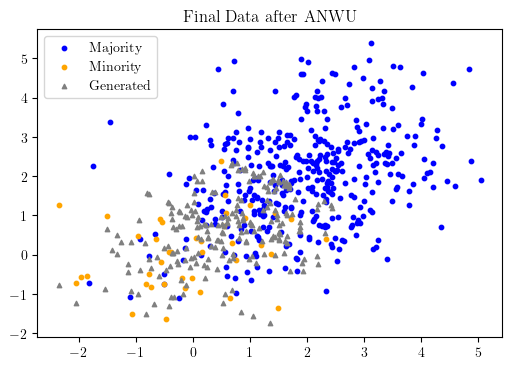

In [118]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def anwu(X, y, k=5, m=2):
    """
    Implements the Adaptive Neighborhood-based Weighted Undersampling (ANWU) algorithm.
    
    Parameters:
    - X: Combined dataset (includes T_pos, T_neg, and T_gen)
    - y: Labels for the dataset (0: Majority, 1: Minority, 2: Generated)
    - k: Number of nearest neighbors
    - m: Number of instances to remove from the majority class in phase 2
    
    Returns:
    - X_final, y_final: The balanced dataset and its labels
    """

    # Step 1: Undersample generated data (Phase 1)
    generated_indices = np.where(y == 2)[0]
    to_remove_gen = []

    for idx in generated_indices:
        nbrs = NearestNeighbors(n_neighbors=k).fit(X)
        N = nbrs.kneighbors([X[idx]], return_distance=False)[0]
        neighbors_labels = y[N]
        majority_count = np.sum(neighbors_labels == 0)

        if majority_count > k / 2:
            to_remove_gen.append(idx)

    # Remove elements in reverse order to avoid index shifting issues
    for idx in sorted(to_remove_gen, reverse=True):
        X = np.delete(X, idx, axis=0)
        y = np.delete(y, idx)

    # Refit the NearestNeighbors model after removing generated data
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)

    # Step 2: Weighted undersampling of majority class (Phase 2)
    majority_indices = np.where(y == 0)[0]
    weights = []

    for idx in majority_indices:
        N = nbrs.kneighbors([X[idx]], return_distance=False)[0]
        neighbors_labels = y[N]
        pos_count = np.sum(neighbors_labels == 1)
        gen_count = np.sum(neighbors_labels == 2)
        weight = pos_count + gen_count
        weights.append((idx, weight))

    weights.sort(key=lambda x: x[1], reverse=True)
    to_remove_maj = [w[0] for w in weights[:m]]

    # Remove elements in reverse order to avoid index shifting issues
    for idx in sorted(to_remove_maj, reverse=True):
        X = np.delete(X, idx, axis=0)
        y = np.delete(y, idx)

    return X, y

# Example usage
# Original majority class data
X_majority = np.random.multivariate_normal([2, 2], [[1.5, 0.5], [0.5, 1.5]], 400)
y_majority = np.zeros(X_majority.shape[0])

# Minority and generated data (assuming these are defined elsewhere)
X_minority = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 40)
X_generated = np.random.multivariate_normal([1, 1], [[1, 0.3], [0.3, 1]], 300)

# Combine the original and generated data
X_combined = np.vstack([X_majority, X_minority, X_generated])
y_combined = np.array([0] * 400 + [1] * 40 + [2] * 300)

# Apply ANWU
X_final, y_final = anwu(X_combined, y_combined, k=5, m=2)

# Visualization of the final dataset
plt.figure(figsize=(6, 4))
plt.scatter(X_final[y_final == 0][:, 0], X_final[y_final == 0][:, 1], c='blue', label='Majority', s=10)
plt.scatter(X_final[y_final == 1][:, 0], X_final[y_final == 1][:, 1], c='orange', label='Minority', s=10)
plt.scatter(X_final[y_final == 2][:, 0], X_final[y_final == 2][:, 1], c='gray', marker='^', label='Generated', s=10)
plt.title('Final Data after ANWU')
plt.legend()
plt.show()